# Data Analytics project - prediction of electric current prices

### Libraries

In [1]:
import datetime
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
import time
from typing import List

from cmdstanpy import CmdStanModel
from sklearn.metrics import mean_squared_error
import seaborn as sns

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Importing data

#### Data 2019

In [2]:
df_ceny: pd.DataFrame = pd.read_csv("../Data/Prices/PL_CENY_NIEZB_RB_20190301_20190331.csv", sep=";", decimal=",")
df_zapotrzebowanie: pd.DataFrame = pd.read_csv("../Data/Load/PL_WYK_KSE_20190301_20190331.csv", encoding="cp1250", sep=";", decimal=",")
df_ceny["Data_i_Godzina"] = df_ceny["Data"].astype(str) + " " + (df_ceny["Godzina"] - 1).astype(str)  # Hours 1-24, changed into 0-23
df_ceny["Data_i_Godzina"] = df_ceny["Data_i_Godzina"].apply(datetime.datetime.strptime, args=("%Y%m%d %H",))
df_ceny = df_ceny[["Data", "Godzina", "Data_i_Godzina", "CRO"]]
df_zapotrzebowanie["Data_i_Godzina"] = df_zapotrzebowanie["Data"].astype(str) + " " + (df_zapotrzebowanie["Godzina"] - 1).astype(str) # Hours 1-24, changed into 0-23
df_zapotrzebowanie["Data_i_Godzina"] = df_zapotrzebowanie["Data_i_Godzina"].apply(datetime.datetime.strptime, args=("%Y-%m-%d %H",))
df_zapotrzebowanie["Dzień tygodnia"] = df_zapotrzebowanie["Data"].astype(str).apply(lambda x: pd.Timestamp(x).day_of_week)
df_list: List[pd.DataFrame] = []
df_naslonecznienie_temp: pd.DataFrame
for file in os.listdir("../Data/Weather2019"):
    df_naslonecznienie_temp = pd.read_csv(f"../Data/Weather2019/{file}", header=6, skipfooter=11, engine="python")
    df_naslonecznienie_temp = df_naslonecznienie_temp.loc[:, ["time", "G(i)", "T2m", "WS10m"]]
    df_naslonecznienie_temp["time"] = df_naslonecznienie_temp["time"].apply(str.__getitem__, args=(slice(None, -2, None),))
    df_naslonecznienie_temp["time"] = df_naslonecznienie_temp["time"].apply(datetime.datetime.strptime, args=("%Y%m%d:%H",))
    df_list.append(df_naslonecznienie_temp)
df_naslonecznienie: pd.DataFrame = pd.concat(df_list)
df_naslonecznienie = df_naslonecznienie.groupby("time").mean().reset_index()
df_naslonecznienie_marzec = df_naslonecznienie.loc[
    df_naslonecznienie["time"].between(datetime.datetime(2019, 3, 1), datetime.datetime(2019, 4, 1), inclusive="left")
    ]
df_naslonecznienie_marzec.reset_index(inplace=True)


#### Data 2020

In [3]:
df_ceny2020: pd.DataFrame = pd.read_csv("../Data/Prices/PL_CENY_NIEZB_RB_20200301_20200331.csv", sep=";", decimal=",")
df_zapotrzebowanie2020: pd.DataFrame = pd.read_csv("../Data/Load/PL_WYK_KSE_20200301_20200331.csv", encoding="cp1250", sep=";", decimal=",")
df_ceny2020["Data_i_Godzina"] = df_ceny2020["Data"].astype(str) + " " + (df_ceny2020["Godzina"] - 1).astype(str)  # Hours 1-24, changed into 0-23
df_ceny2020["Data_i_Godzina"] = df_ceny2020["Data_i_Godzina"].apply(datetime.datetime.strptime, args=("%Y%m%d %H",))
df_ceny2020 = df_ceny2020[["Data", "Godzina", "Data_i_Godzina", "CRO"]]
df_zapotrzebowanie2020["Data_i_Godzina"] = df_zapotrzebowanie2020["Data"].astype(str) + " " + (df_zapotrzebowanie2020["Godzina"] - 1).astype(str) # Hours 1-24, changed into 0-23
df_zapotrzebowanie2020["Data_i_Godzina"] = df_zapotrzebowanie2020["Data_i_Godzina"].apply(datetime.datetime.strptime, args=("%Y-%m-%d %H",))
df_zapotrzebowanie2020["Dzień tygodnia"] = df_zapotrzebowanie2020["Data"].astype(str).apply(lambda x: pd.Timestamp(x).day_of_week)
df_list2020: List[pd.DataFrame] = []
df_naslonecznienie_temp: pd.DataFrame
for file in os.listdir("../Data/Weather2020"):
    df_naslonecznienie_temp = pd.read_csv(f"../Data/Weather2020/{file}", header=6, skipfooter=11, engine="python")
    df_naslonecznienie_temp = df_naslonecznienie_temp.loc[:, ["time", "Gb(i)", "Gd(i)", "Gr(i)", "T2m", "WS10m"]]
    df_naslonecznienie_temp["G(i)"] = df_naslonecznienie_temp[["Gb(i)", "Gd(i)", "Gr(i)"]].sum(axis=1)
    df_naslonecznienie_temp["time"] = df_naslonecznienie_temp["time"].apply(str.__getitem__, args=(slice(None, -2, None),))
    df_naslonecznienie_temp["time"] = df_naslonecznienie_temp["time"].apply(datetime.datetime.strptime, args=("%Y%m%d:%H",))
    df_list2020.append(df_naslonecznienie_temp)
df_naslonecznienie2020: pd.DataFrame = pd.concat(df_list2020)
df_naslonecznienie2020 = df_naslonecznienie2020.groupby("time").mean().reset_index()
df_naslonecznienie_marzec2020 = df_naslonecznienie2020.loc[
    df_naslonecznienie2020["time"].between(datetime.datetime(2020, 3, 1), datetime.datetime(2020, 4, 1), inclusive="left")
    ]
df_naslonecznienie_marzec2020.reset_index(inplace=True)

## Comparison of the models

### Prediction for 2020 - model 2

INFO:cmdstanpy:compiling stan file /home/ProjektDataAnalytics/Comparison_of_models/final_posterior_model2.stan to exe file /home/ProjektDataAnalytics/Comparison_of_models/final_posterior_model2
INFO:cmdstanpy:compiled model executable: /home/ProjektDataAnalytics/Comparison_of_models/final_posterior_model2
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing


Processing csv files: /tmp/tmptvwunfzr/final_posterior_model2-20230711161801_1.csv, /tmp/tmptvwunfzr/final_posterior_model2-20230711161801_2.csv, /tmp/tmptvwunfzr/final_posterior_model2-20230711161801_3.csv, /tmp/tmptvwunfzr/final_posterior_model2-20230711161801_4.csv

Checking sampler transitions treedepth.
3786 of 4000 (94.65%) transitions hit the maximum treedepth limit of 10, or 2^10 leapfrog steps.
Trajectories that are prematurely terminated due to this limit will result in slow exploration.
For optimal performance, increase this limit.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

The following parameters had split R-hat greater than 1.05:
  a_hour, a_day, b_day, offset_demand, demand_samples[1], demand_samples[2], demand_samples[3], demand_samples[4], demand_samples[5], demand_samples[6], demand_samples[7], demand_samples[8], d

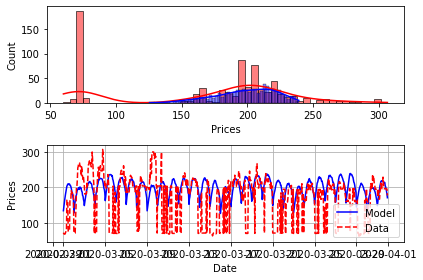

RMSE = 70.40535122135107 / (max possible) 180.57203659556257


In [12]:
data = df_zapotrzebowanie[["Godzina", "Data_i_Godzina", "Dzień tygodnia"]]
data.insert(len(data.columns), "Irradiance", [
    round(df_naslonecznienie_marzec.loc[df_naslonecznienie_marzec["time"] == data.iloc[i]["Data_i_Godzina"]]["G(i)"].values[0], 0) 
    for i in range(len(data))
    ])
data.insert(len(data.columns), "Wind speed", [
    round(df_naslonecznienie_marzec.loc[df_naslonecznienie_marzec["time"] == data.iloc[i]["Data_i_Godzina"]]["WS10m"].values[0], 2) 
    for i in range(len(data))
    ])
data.insert(len(data.columns), "Prices", [
    df_ceny.loc[df_ceny["Data_i_Godzina"] == data.iloc[i]["Data_i_Godzina"]]["CRO"].values[0] for i in range(len(data))
    ])

data2020 = df_zapotrzebowanie2020[["Godzina", "Data_i_Godzina", "Dzień tygodnia"]]
data2020.insert(len(data2020.columns), "Irradiance", [
    round(df_naslonecznienie_marzec2020.loc[df_naslonecznienie_marzec2020["time"] == data2020.iloc[i]["Data_i_Godzina"]]["G(i)"].values[0], 0) 
    for i in range(len(data2020))
    ])
data2020.insert(len(data2020.columns), "Wind speed", [
    round(df_naslonecznienie_marzec2020.loc[df_naslonecznienie_marzec2020["time"] == data2020.iloc[i]["Data_i_Godzina"]]["WS10m"].values[0], 2) 
    for i in range(len(data2020))
    ])
data2020.insert(len(data2020.columns), "Prices", [
    df_ceny2020.loc[df_ceny2020["Data_i_Godzina"] == data2020.iloc[i]["Data_i_Godzina"]]["CRO"].values[0] for i in range(len(data2020))
    ])
y_true = data2020["Prices"]

final_posterior2=CmdStanModel(stan_file='final_posterior_model2.stan')
predictions2 = final_posterior2.sample(show_progress=False, data=dict(
    N_samples=len(data), day_of_week_historic=data["Dzień tygodnia"], hour_historic=data["Godzina"], wind_speed_historic=data["Wind speed"], 
    irradiance_historic=data["Irradiance"], prices_samples=data["Prices"],
    N=len(data2020), day_of_week=data2020["Dzień tygodnia"], hour=data2020["Godzina"], wind_speed=data2020["Wind speed"], 
    irradiance=data2020["Irradiance"]
    ))
print(predictions2.diagnose())
df_predictions2 = predictions2.draws_pd()
y_pred2 = df_predictions2.mean()[[f"prices[{i}]" for i in range(1, len(data2020) + 1)]]

ax = plt.subplot(2, 1, 1)
sns.histplot(y_true, kde=True, ax=ax, bins=50, color="r")
plt.xlabel("Prices")
sns.histplot(y_pred2, kde=True, ax=ax, bins=50, color="b")
plt.xlabel("Prices")
ax = plt.subplot(2, 1, 2)
ax.plot(data2020["Data_i_Godzina"], y_pred2, "b-",
        data2020["Data_i_Godzina"], y_true, "r--",)
plt.xlabel("Date")
plt.ylabel("Prices")
plt.legend(["Model", "Data"])
plt.grid(True)
plt.tight_layout()
plt.show()
print(f'RMSE = {mean_squared_error(y_true.values, y_pred2.values, squared=False)} '
      f'/ (max possible) {mean_squared_error(y_true.values, np.zeros_like(y_true.values), squared=False)}')

### Prediction for 2020 - model 3

INFO:cmdstanpy:compiling stan file /home/ProjektDataAnalytics/Comparison_of_models/final_posterior_model3.stan to exe file /home/ProjektDataAnalytics/Comparison_of_models/final_posterior_model3
INFO:cmdstanpy:compiled model executable: /home/ProjektDataAnalytics/Comparison_of_models/final_posterior_model3
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing


Processing csv files: /tmp/tmptvwunfzr/final_posterior_model3-20230711164216_1.csv, /tmp/tmptvwunfzr/final_posterior_model3-20230711164216_2.csv, /tmp/tmptvwunfzr/final_posterior_model3-20230711164216_3.csv, /tmp/tmptvwunfzr/final_posterior_model3-20230711164216_4.csv

Checking sampler transitions treedepth.
1598 of 4000 (39.95%) transitions hit the maximum treedepth limit of 10, or 2^10 leapfrog steps.
Trajectories that are prematurely terminated due to this limit will result in slow exploration.
For optimal performance, increase this limit.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

The following parameters had fewer than 0.001 effective draws per transition:
  a_hour, demand_samples[21], demand_samples[22], demand_samples[23], demand_samples[24], demand_samples[168], demand_samples[188], demand_samples[189], demand_samples[190], demand_samples[191], demand_samples[1

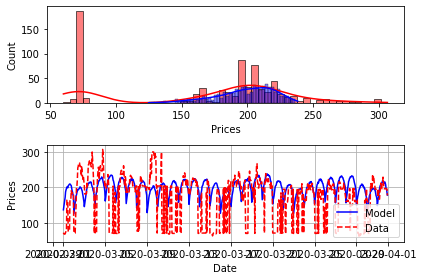

RMSE = 69.8426734148052 / (max possible) 180.57203659556257


In [13]:
# Data is the same as previously
final_posterior3=CmdStanModel(stan_file='final_posterior_model3.stan')
predictions3 = final_posterior3.sample(show_progress=False, data=dict(
    N_samples=len(data), day_of_week_historic=data["Dzień tygodnia"], hour_historic=data["Godzina"], wind_speed_historic=data["Wind speed"], 
    prices_samples=data["Prices"],
    N=len(data2020), day_of_week=data2020["Dzień tygodnia"], hour=data2020["Godzina"], wind_speed=data2020["Wind speed"]
    ))
print(predictions3.diagnose())
df_predictions3 = predictions3.draws_pd()
y_pred3 = df_predictions3.mean()[[f"prices[{i}]" for i in range(1, len(data2020) + 1)]]

ax = plt.subplot(2, 1, 1)
sns.histplot(y_true, kde=True, ax=ax, bins=50, color="r")
plt.xlabel("Prices")
sns.histplot(y_pred3, kde=True, ax=ax, bins=50, color="b")
plt.xlabel("Prices")
ax = plt.subplot(2, 1, 2)
ax.plot(data2020["Data_i_Godzina"], y_pred3, "b-",
        data2020["Data_i_Godzina"], y_true, "r--",)
plt.xlabel("Date")
plt.ylabel("Prices")
plt.legend(["Model", "Data"])
plt.grid(True)
plt.tight_layout()
plt.show()
print(f'RMSE = {mean_squared_error(y_true.values, y_pred3.values, squared=False)} '
      f'/ (max possible) {mean_squared_error(y_true.values, np.zeros_like(y_true.values), squared=False)}')

### Comparison using information criteria

/usr/local/lib/python3.9/site-packages/arviz/stats/stats.py:1635: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/usr/local/lib/python3.9/site-packages/arviz/stats/stats.py:1635: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


                          rank         waic      p_waic   d_waic    weight  \
Model_with_irradiance        0 -4733.280382  371.314863  0.00000  0.654092   
Model_without_irradiance     1 -4733.518211  371.251251  0.23783  0.345908   

                                se       dse  warning waic_scale  
Model_with_irradiance     0.872827  0.000000     True        log  
Model_without_irradiance  0.926194  1.242111     True        log  


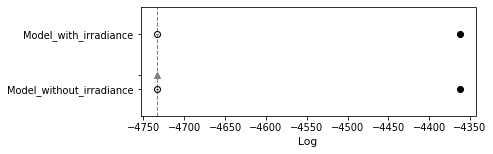

In [14]:
import arviz as az

comparison = az.compare({"Model_with_irradiance": predictions2, "Model_without_irradiance": predictions3}, ic="waic")
print(comparison)
az.plot_compare(comparison)
plt.show()

/usr/local/lib/python3.9/site-packages/arviz/stats/stats.py:811: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/arviz/stats/stats.py:811: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


                          rank          loo       p_loo     d_loo    weight  \
Model_without_irradiance     0 -4954.314111  592.047150  0.000000  0.618524   
Model_with_irradiance        1 -4956.698076  594.732556  2.383965  0.381476   

                                se       dse  warning loo_scale  
Model_without_irradiance  3.243580  0.000000     True       log  
Model_with_irradiance     3.198381  4.489707     True       log  


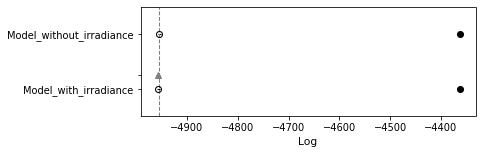

In [15]:
comparison = az.compare({"Model_with_irradiance": predictions2, "Model_without_irradiance": predictions3}, ic="loo")
print(comparison)
az.plot_compare(comparison)
plt.show()